# Dependencies

In [34]:
import pandas as pd
import numpy as np

In [35]:
df = pd.read_csv('clean_data/data.csv')
df.head()

,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1926-07,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,...,7.70,1.92,-23.79,0.07,1.87,4.61,-0.54,2.89,-5.77,5.20
1,1926-08,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,...,-2.38,4.85,5.39,-0.75,-0.13,11.83,2.57,5.30,0.32,6.76
2,1926-09,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,...,-5.54,0.08,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-4.81,-3.86
3,1926-10,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,...,-5.08,-2.62,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,-0.94,-8.49
4,1926-11,6.75,6.26,-99.99,7.29,4.55,0.00,1.82,-6.40,-0.54,...,3.84,1.61,4.67,6.52,4.33,-2.97,3.58,2.21,5.13,4.00


In [36]:
df.max()

Date     2024-11
Agric      91.34
Food       32.63
Soda        38.9
Beer       87.61
Smoke      33.04
Toys      140.45
Fun        69.57
Books      54.75
Hshld      58.33
Clths       41.4
Hlth       36.41
MedEq      30.28
Drugs       39.5
Chems       46.6
Rubbr      98.43
Txtls      59.18
BldMt      42.41
Cnstr       67.4
Steel      80.84
FabPr      40.08
Mach       52.08
ElcEq      59.58
Autos      81.88
Aero       72.37
Ships      63.37
Guns       32.87
Gold       79.52
Mines       46.1
Coal      125.43
Oil        39.08
Util       43.46
Telcm      28.17
PerSv      84.67
BusSv      56.83
Comps      54.04
Chips      62.78
LabEq      25.42
Paper      300.0
Boxes      43.19
Trans       65.4
Whlsl      57.64
Rtail      43.51
Meals      30.65
Banks      41.79
Insur      75.11
RlEst      65.22
Fin        66.79
Other       45.3
dtype: object

In [37]:
df.loc[:, df.columns != 'Date'] = df.loc[:, df.columns != 'Date']/100
df.loc[:, df.columns != 'Date'].mean()

Agric    0.009771
Food     0.009461
Soda    -0.368907
Beer     0.011694
Smoke    0.011503
Toys     0.009529
Fun      0.012748
Books    0.009950
Hshld    0.009158
Clths    0.009070
Hlth    -0.431361
MedEq    0.011254
Drugs    0.010948
Chems    0.010348
Rubbr   -0.039643
Txtls    0.009503
BldMt    0.010483
Cnstr    0.011245
Steel    0.009722
FabPr   -0.370604
Mach     0.010967
ElcEq    0.011595
Autos    0.012084
Aero     0.013871
Ships    0.010297
Guns    -0.368266
Gold    -0.370009
Mines    0.010363
Coal     0.011095
Oil      0.010371
Util     0.008864
Telcm    0.008336
PerSv   -0.000868
BusSv    0.010991
Comps    0.012269
Chips    0.012556
LabEq    0.011478
Paper   -0.017763
Boxes    0.010551
Trans    0.009398
Whlsl    0.008613
Rtail    0.010676
Meals    0.010813
Banks    0.011592
Insur    0.010802
RlEst    0.008506
Fin      0.011162
Other    0.007636
dtype: float64

In [44]:
mean = df.loc[:, df.columns != 'Date'].mean()
var = df.loc[:, df.columns != 'Date'].std()

var.min()

np.float64(0.0464342906353121)

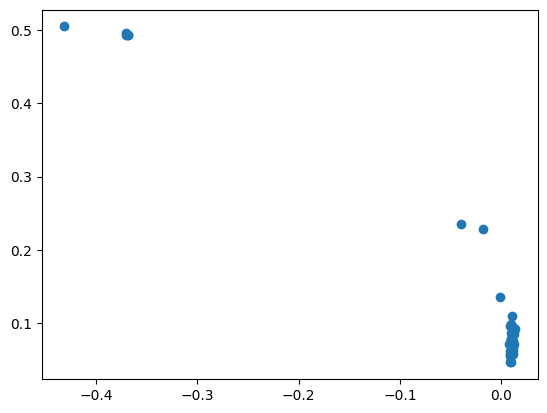

In [43]:
import matplotlib.pyplot as plt

plt.scatter(mean, var)